In [1]:
import scgen
import scanpy as sc

Using TensorFlow backend.


## Reading train and validation data

In [2]:
train = sc.read("./tests/data/train_kang.h5ad",
                backup_url="https://goo.gl/33HtVh")

Let's remove stimulated CD4T cells from both the training set. This is just for the sake
of this notebook, in practice, you do not need to do this step, just pass the train data

In [3]:
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]

## Creating and training the model

In [4]:
scg = scgen.VAEArithKeras(x_dimension= train.shape[1], model_path="./models/test")

We train the model for 100 epochs

In [5]:
scg.train(train_data=train_new, n_epochs=100)

## Prediction

After training the model you can pass the adata of the cells
you want to perturb. Here we pass unperturbed CD4T cells


In [6]:
unperturbed_cd4t = train[((train.obs["cell_type"] == "CD4T") & (train.obs["condition"] == "control"))]


Here the 'adata' contains the cells that you want estimate the perturbation based on them. we set
"ctrl" to our control labels and "stim" to our stimulated labels. If you apply it in another context
just set "ctrl" :"your_control_label" and "stim":"your_stimulated_label". the returned value is a numpy
matrix of our predicted cells and the second one is the difference vector between our conditions which might
become useful later.

In [7]:
pred, delta = scg.predict(adata=train_new, adata_to_predict=unperturbed_cd4t,
                          conditions={"ctrl": "control", "stim": "stimulated"}, cell_type_key="cell_type", condition_key="condition")

In the previous block, the difference between conditions is by default computed using all cells (obs_key="all"). However, some times you might have a rough idea that which groups (e.g. cell types) are close to your cell type of interest. This  might give you more accurate predictions. For example, we can restrict the delta computation only to CD8T and NK cells. We provide dictionary in form of obs_key={"cell_type": ["CD8T", "NK"]} which is telling the model to look at "cell_type" labels in adata (here: train_new) and only compute the delta vector based on "CD8T" and "NK" cells :

>pred, delta = scg.predict(adata=train_new, adata_to_predict=unperturbed_cd4t,
                          conditions={"ctrl": "control", "stim": "stimulated"}, 
                          cell_type_key="cell_type", condition_key="condition",
                         obs_key={"cell_type": ["CD8T", "NK"]})`

## Evaluation of the predcition

In [10]:
pred_adata = sc.AnnData(pred, obs={"condition":["pred"]*len(pred)}, var={"var_names":train.var_names})


Extracting both control and real stimulated CD4T cells from our dataset

In [11]:
CD4T = train[train.obs["cell_type"] =="CD4T"]

Merging predicted cells with real ones 

In [12]:
all_adata = CD4T.concatenate(pred_adata)

### Embedding all real and predicted cells in one PCA plot 

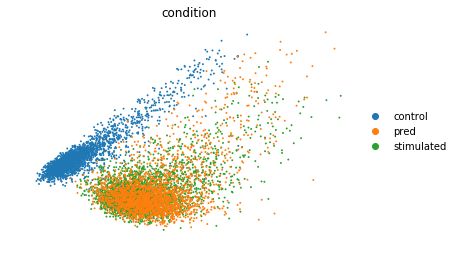

In [14]:
sc.tl.pca(all_adata)
sc.pl.pca(all_adata, color="condition", frameon=False)

### Mean correlation plot

You can also visualize your mean gene expression of your predicted cells vs control cells while
highlighting your genes of interest (here top 10 differentially expressed genes)

In [30]:
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]

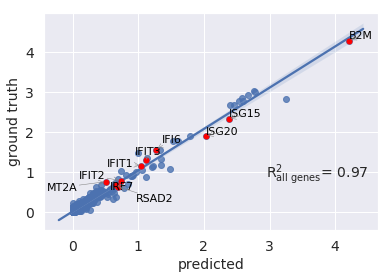

In [31]:
r2_value = scgen.plotting.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={
                                            "x": "pred", "y": "stimulated"},
                                        gene_list=diff_genes[:10],
                                        labels={"x": "predicted",
                                                "y": "ground truth"},
                                        path_to_save="./reg_mean1.pdf",
                                        show=True,
                                        legend=False)

You can also pass a list of differentially epxressed genes to compute correlation based on them

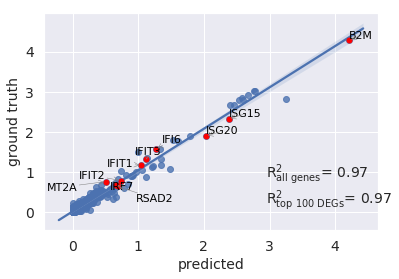

In [32]:
r2_value = scgen.plotting.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={
                                            "x": "pred", "y": "stimulated"},
                                        gene_list=diff_genes[:10],
                                        top_100_genes= diff_genes,
                                        labels={"x": "predicted",
                                                "y": "ground truth"},
                                        path_to_save="./reg_mean1.pdf",
                                        show=True,
                                        legend=False)

### Violin plot for a specific gene

Let's go deeper and compare the distribution of "ISG15", the top DEG between stimulated and control CD4T cells between predcited and real cells

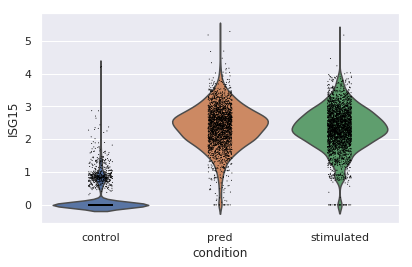

In [37]:
sc.pl.violin(all_adata, keys="ISG15", groupby="condition")